In [89]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
import torch
import botorch
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.autograd.functional import vhp

In [90]:
dataset = datasets.MNIST(
    'MNIST', train=True, download=True,
    transform=transforms.ToTensor())
train_dataset = torch.utils.data.Subset(dataset, indices=range(1000))
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=4)

In [91]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 256)
        self.fc7 = nn.Linear(256, 512)
        self.fc8 = nn.Linear(512, 784)
    
    def forward(self, x):
        x = x / x.norm()
        x = x.reshape(x.shape[0], 28 * 28)
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc6(h))
        h = torch.relu(self.fc7(h))
        h = self.fc8(h)
        return h

In [92]:
model = Autoencoder()

In [93]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_f = torch.nn.MSELoss()
epochs = 100
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        total_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            h = model(x)
            loss = loss_f(h.flatten(), x.flatten())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (i + 1)
        pbar.set_description(f"loss:{avg_loss:.6f}")
        pbar.update(1)

loss:0.110251:   1%|          | 1/100 [00:02<04:45,  2.88s/it]


KeyboardInterrupt: 

In [94]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
loss_f = torch.nn.MSELoss()
epochs = 500
loss_list = []
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        total_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            h = model(x)
            loss = loss_f(h.flatten(), x.flatten())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_list.append(loss.item())
        avg_loss = total_loss / (i + 1)
        pbar.set_description(f"loss:{avg_loss:.6f}")
        pbar.update(1)

loss:0.018617: 100%|██████████| 500/500 [12:59<00:00,  1.56s/it]


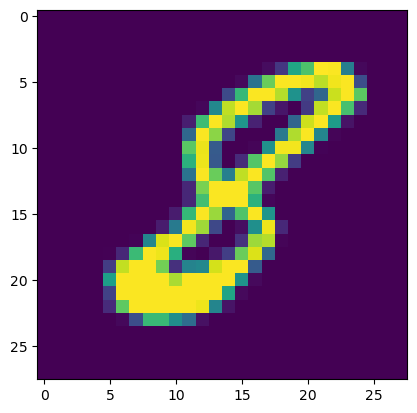

In [7]:
plt.imshow(x[0].reshape(28,28,1))

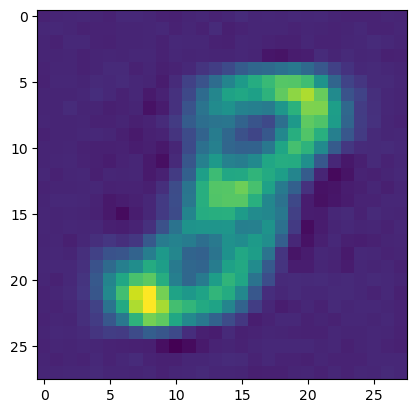

In [9]:
plt.imshow(h[0].reshape(28,28,1).detach().numpy())

In [15]:
dim_list = [784, 512, 256, 128, 256, 512, 784]

In [14]:
def get_matrix(w, dim_list):
    matrix = []
    start = 0
    dim1 = dim_list[0]
    for dim2 in dim_list[1:]:
        matrix.append(w[start:dim1*dim2].reshape(dim1, dim2))
        dim1 = dim2
    return matrix

In [12]:
def model_func(x, w):
    h = x.reshape(-1, 784)
    w_matrix = get_matrix(w, dim_list)
    for w_m in w_matrix[:-1]:
        h = torch.relu(h @ w_m)
    h = h @ w_matrix[-1]
    l = torch.nn.MSELoss()
    return l(x.flatten(), h.flatten())

In [13]:
def func_generator(x):
    def func(w):
        return model_func(x, w)
    return func

In [73]:
class cubic(torch.optim.Optimizer):
    def __init__(self, params, func_generator, eps=0.01, l=5, rho=1):
        super(cubic, self).__init__(params, defaults={})
        self.generator = func_generator
        self.x = params[0]
        self.eps = eps
        self.l = l
        self.rho = rho
        self.stop = False
        self.deltam_list = []
    
    def update_f(self, x):
        self.f = self.generator(x)
    
    def finalsolver(self, g):
        delta = torch.zeros_like(g)
        gm = g
        eta = 0.05 / self.l
        while gm.norm() > self.eps / 2:
            delta = delta - eta * gm
            gm = g + vhp(self.f, self.x, delta)[1].t() + self.rho / 2 * delta.norm() * delta
        return delta
    
    def subsolver(self, g):
        if g.norm() >= self.l ** 2 / self.rho:
            a = g @ vhp(self.f, self.x, g)[1].t() / self.rho / g.norm() ** 2
            rc = -a + torch.sqrt(a ** 2 + 2 * g.norm() / self.rho)
            delta = -rc * g / g.norm()
        else:
            delta = torch.zeros_like(g)
            sigma = 1 * sqrt(self.eps * self.rho) / self.l
            # sigma = 0.01
            eta = 0.05 / self.l
            xi = botorch.utils.sampling.sample_hypersphere(g.shape[0]).reshape(-1)
            gtil = g + sigma * xi
            for _ in range(10):
                delta -= eta * (gtil + vhp(self.f, self.x, delta)[1].t() + self.rho / 2 * delta.norm() * delta)
        deltam = g @ delta + 0.5 * delta @ vhp(self.f, self.x, delta)[1].t() + self.rho / 6 * delta.norm() ** 3
        return delta, deltam
    
    def step(self):
        gt = self.x.grad.data
        delta, deltam = self.subsolver(gt)
        # if deltam >= -0.01 * sqrt(self.eps ** 3 / self.rho):
        #     delta = self.finalsolver(gt)
        #     self.stop = True
        self.x.data += delta
        self.deltam_list.append(deltam)

In [64]:
model_func(x, w)

tensor(0.1157, grad_fn=<MseLossBackward0>)

In [82]:
torch.manual_seed(598)
w = torch.empty(1130496, requires_grad=True)
nn.init.normal_(w, std=0.02)

tensor([ 0.0055, -0.0133,  0.0022,  ..., -0.0026,  0.0016, -0.0013],
       requires_grad=True)

In [83]:
optimizer = cubic([w], func_generator, eps=1, l=0.001, rho=0.05)
loss_list = []
epochs = 500
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        total_loss = 0
        for x, y in train_dataloader:
            optimizer.zero_grad()
            loss = model_func(x, w)
            loss.backward()
            loss_list.append(loss.item())
            total_loss += loss.item()
            optimizer.update_f(x)
            optimizer.step()
            if optimizer.stop:
                break
        avg_loss = total_loss / 10
        pbar.set_description(f'loss: {avg_loss}')
        pbar.update(1)

loss: 0.029751200601458548: 100%|██████████| 500/500 [17:37<00:00,  2.12s/it]


In [85]:
np.save('CSR',np.array(loss_list))

(0.0, 0.2)

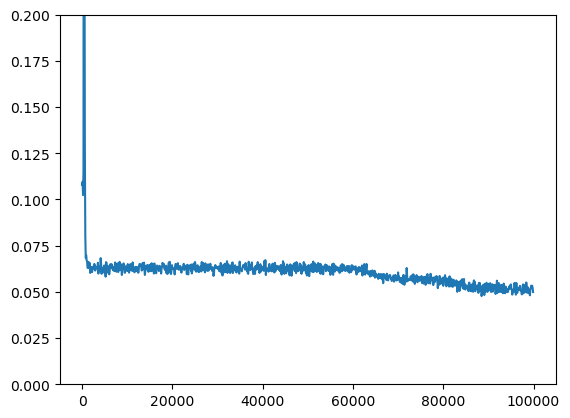

In [77]:
ax = plt.gca()
ax.plot(np.arange(len(loss_list)) * 100, loss_list)
# ax.plot(np.arange(len(loss_list)) * 100, [func['minimal']] * len(loss_list))
ax.set_ylim([0, 0.2])

In [ ]:
class hybrid(torch.optim.Optimizer):
    def __init__(self, params, func_generator, eps=0.01, l=5, rho=1, alpha=0.7):
        super(hybrid, self).__init__(params, defaults={})
        self.generator = func_generator
        self.x = params[0]
        self.eps = eps
        self.l = l
        self.rho = rho
        self.stop = False
        self.state = torch.zeros_like(self.x)
        self.alpha = alpha
    
    def update_f(self, x):
        self.f = self.generator(x)
    
    def finalsolver(self, g):
        delta = torch.zeros_like(g)
        gm = g
        eta = 0.05 / self.l
        while gm.norm() > self.eps / 2:
            delta = delta - eta * gm
            gm = g + vhp(self.f, self.x, delta)[1].t() + self.rho / 2 * delta.norm() * delta
        return delta
    
    def subsolver(self, g):
        if g.norm() >= self.l ** 2 / self.rho:
            a = g @ vhp(self.f, self.x, g)[1].t() / self.rho / g.norm() ** 2
            rc = -a + torch.sqrt(a ** 2 + 2 * g.norm() / self.rho)
            delta = -rc * g / g.norm()
        else:
            delta = torch.zeros_like(g)
            sigma = 1e-1 * sqrt(self.eps * self.rho) / self.l
            # sigma = 0.01
            eta = 0.05 / self.l
            xi = botorch.utils.sampling.sample_hypersphere(g.shape[0]).reshape(-1)
            gtil = g + sigma * xi
            for _ in range(10):
                delta -= eta * (gtil + vhp(self.f, self.x, delta)[1].t() + self.rho / 2 * delta.norm() * delta)
        deltam = g @ delta + 0.5 * delta @ vhp(self.f, self.x, delta)[1].t() + self.rho / 6 * delta.norm() ** 3
        return delta, deltam
    
    def step(self):
        gt = self.x.grad.data
        self.state += gt * gt 
        delta, deltam = self.subsolver(gt)
        delta_ada = - 0.01 / (torch.sqrt(self.state) + 1e-10) * gt
        self.alpha = torch.sigmoid(gt @ gt * 100)
        self.x.data += self.alpha * delta + (1 - self.alpha) * delta_ada

In [79]:
def model_draw(x, w):
    h = x.reshape(-1, 784)
    w_matrix = get_matrix(w, dim_list)
    for w_m in w_matrix[:-1]:
        h = torch.relu(h @ w_m)
    h = h @ w_matrix[-1]
    return h